In [5]:
# %% Import dependencies
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("⚠️ No GPU found, using CPU.")

max_padding = 1000

# %% Load yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# %% Helper functions
@tf.function
def load_wav_16k_mono(filename, test=False):
    """ read in a waveform file and convert to 16 kHz mono """
    global max_padding
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    if test == False:
        zero_padding = tf.zeros([max_padding] - tf.shape(wav), dtype=tf.float32)
        waveform = tf.cast(wav, tf.float32)
        wav = tf.concat([waveform, zero_padding], 0)
    return wav

def get_label(file_path):
    """ get label of file """
    parts = file_path.split(os.path.sep)
    return parts[-2]

def loadData(data_dir):
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    return filenames, commands

def setMaxPadding(filenames):
    global max_padding
    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    for waveform in waveform_ds:
        if waveform.shape[0] > max_padding:
            max_padding = waveform.shape[0]

def get_waveform_and_label(file_path):
    waveform = load_wav_16k_mono(file_path, test=True)
    return waveform

def preprocessCell(files):
    filenames = tf.convert_to_tensor(files)
    
    def extract_label(file_path):
        file_path_str = file_path.numpy().decode('utf-8')
        label_str = get_label(file_path_str)
        return file_path_str, namedict[label_str]

    def tf_extract_label(file_path):
        path, label = tf.py_function(
            extract_label,
            inp=[file_path],
            Tout=(tf.string, tf.int64)
        )
        path.set_shape([])
        label.set_shape([])
        return path, label

    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    files_ds = files_ds.map(tf_extract_label, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(load_wav_for_map, num_parallel_calls=tf.data.AUTOTUNE)
    files_ds = files_ds.map(extract_embedding, num_parallel_calls=tf.data.AUTOTUNE)
    return files_ds

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

# %% Data preprocessing
data_dir = r"C:\Users\FUJITSU\Documents\Aug_data"
filenames, commands = loadData(data_dir)
namedict = {i: n for n, i in enumerate(commands)}
dictoname = {n: i for n, i in enumerate(commands)}

setMaxPadding(filenames)

# Split data into 80% train, 10% validation, 10% test
num_samples = len(filenames)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Show class distribution in test set
test_files = filenames[train_size+val_size:]
test_classes = [get_label(f.numpy().decode('utf-8')) for f in test_files]
class_counts = {cls: test_classes.count(cls) for cls in commands}
print("\nTest set class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} samples")

train_files = filenames[:train_size]
val_files = filenames[train_size:train_size+val_size]
test_files = filenames[train_size+val_size:]

train_ds = preprocessCell(train_files)
val_ds = preprocessCell(val_files)

# Cache datasets
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# %% Create model
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(commands))
], name='my_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=9,
                                            restore_best_weights=True)

# %% Train the model
history = my_model.fit(train_ds,
                       epochs=150,
                       validation_data=val_ds,
                       callbacks=callback)

# Save the model
saved_model_path = './model'
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=0), name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

print("✅ Training complete and model saved")

⚠️ No GPU found, using CPU.


Total samples: 1296
Training samples: 1036
Validation samples: 129
Test samples: 131

Test set class distribution:
belly_pain: 21 samples
burping: 22 samples
discomfort: 23 samples
hungry: 16 samples
Other: 28 samples
tired: 21 samples


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 263,942
Trainable params: 263,942
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150


32/33 [============================>.] - ETA: 0s - loss: 1.4900 - accuracy: 0.3628WARNING:tensorflow:Model was constructed with shape (None, 1024) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name='input_embedding'), name='input_embedding', description="created by layer 'input_embedding'"), but it was called on an input with incompatible shape (None, None, 1024).


33/33 [==============================] - 321s 2s/step - loss: 1.4882 - accuracy: 0.3633 - val_loss: 1.3775 - val_accuracy: 0.4114
Epoch 2/150
33/33 [==============================] - 3s 76ms/step - loss: 1.3502 - accuracy: 0.4231 - val_loss: 1.2765 - val_accuracy: 0.4568
Epoch 3/150
33/33 [==============================] - 3s 68ms/step - loss: 1.2788 - accuracy: 0.4564 - val_loss: 1.2897 - val_accuracy: 0.4341
Epoch 4/150
33/33 [==============================] - 7s 170ms/step - loss: 1.2632 - accuracy: 0.4668 - val_loss: 1.2414 - val_accuracy: 0.4862
Epoch 5/150
33/33 [==============================] - 5s 133ms/step - loss: 1.2421 - accuracy: 0.4663 - val_loss: 1.2304 - val_accuracy: 0.4612
Epoch 6/150
33/33 [==============================] - 4s 98ms/step - loss: 1.2224 - accuracy: 0.4767 - val_loss: 1.2174 - val_accuracy: 0.4729
Epoch 7/150
33/33 [==============================] - 3s 93ms/step - loss: 1.2107 - accuracy: 0.4870 - val_loss: 1.1796 - val_accuracy: 0.4878
Epoch 8/150
33/3

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


✅ Training complete and model saved


📈 Evaluating model on test set...



📊 Classification Report:
              precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00        28
     burping       0.83      0.95      0.89        41
  discomfort       0.93      0.91      0.92        45
      hungry       0.94      0.83      0.88        36
       Other       0.86      0.95      0.90        39
       tired       0.88      0.78      0.83        46

    accuracy                           0.90       235
   macro avg       0.91      0.90      0.90       235
weighted avg       0.90      0.90      0.90       235



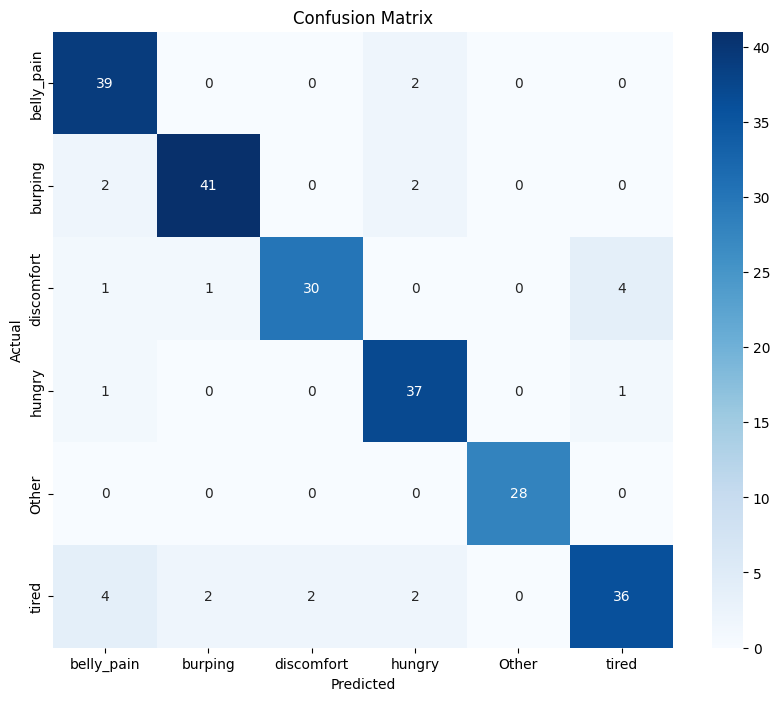


🗂️ Test Set Class Distribution:
belly_pain: 41 samples
burping: 45 samples
discomfort: 36 samples
hungry: 39 samples
Other: 28 samples
tired: 46 samples


In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow_io as tfio

# --- Load the saved model ---
model_path = './model'
model = tf.keras.models.load_model(model_path, compile=False)

# Compile model (required before evaluation)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# --- Helper Functions ---

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def get_label(file_path):
    parts = file_path.split(os.path.sep)
    return parts[-2]

# --- Load Data ---

data_dir = r"C:\Users\FUJITSU\Documents\Aug_data"
commands = np.array(tf.io.gfile.listdir(data_dir))
commands = commands[commands != 'README.md']

namedict = {i: n for n, i in enumerate(commands)}
dictoname = {n: i for i, n in namedict.items()}

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)
train_size = int(0.7 * num_samples)
val_size = int(0.1 * num_samples)
test_files = filenames[train_size + val_size:]

# --- Evaluate Model Sample-by-Sample ---

print("📈 Evaluating model on test set...")
y_true = []
y_pred = []

for file_tensor in test_files:
    file_path = file_tensor.numpy().decode('utf-8')
    label = get_label(file_path)
    wav = load_wav_16k_mono(file_path)
    
    # Ensure input shape is correct: (None,) not (1, None)
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    prediction = model(wav)  # Direct input as 1D waveform
    predicted_label = tf.argmax(prediction, axis=-1).numpy()
    
    y_true.append(namedict[label])
    y_pred.append(predicted_label)

# --- Compute and Display Results ---

y_true_names = [dictoname[label] for label in y_true]
y_pred_names = [dictoname[label] for label in y_pred]

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true_names, y_pred_names, target_names=commands))

# Confusion Matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=commands)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=commands, yticklabels=commands)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Test Set Class Distribution ---
test_classes = [get_label(f.numpy().decode('utf-8')) for f in test_files]
class_counts = {cls: test_classes.count(cls) for cls in commands}
print("\n🗂️ Test Set Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} samples")



🎤 Recording 8 seconds of audio at 16000Hz...
🧹 Applying advanced noise reduction and filtering...
✅ Cleaned audio saved as 'C:\Users\FUJITSU\Documents\Cleanaudio\testing.wav'
✅ Model loaded successfully

🔊 Detected cry category: Other (51% confidence)

📊 Class Probabilities:
Belly Pain   0%
Burping      44%
Discomfort   2%
Hungry       2%
Tired        0%
Other        51%


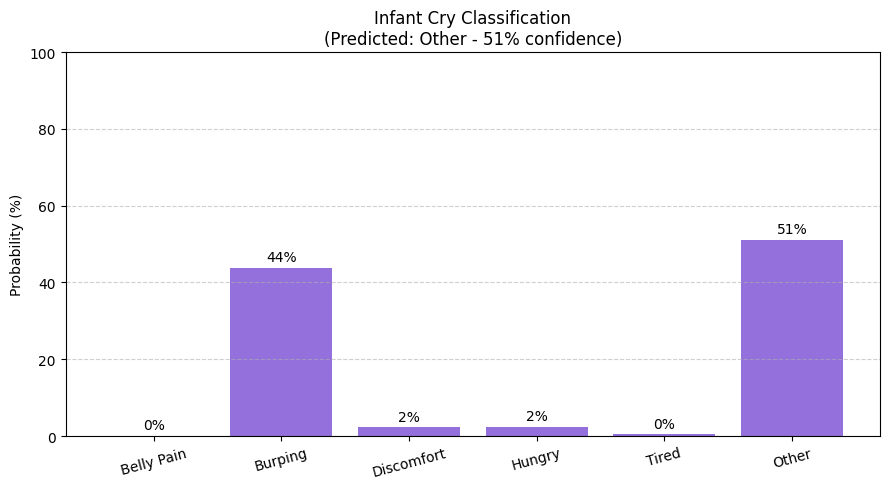

C:\Users\FUJITSU\Documents\Cleanaudio\testing.wav

In [10]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import sounddevice as sd
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter, filtfilt
import noisereduce as nr
import matplotlib.pyplot as plt
from IPython.display import FileLink, display

# Configuration
DURATION = 8  # seconds
SAMPLE_RATE = 16000  # Record directly at target sample rate
TARGET_SAMPLE_RATE = 16000  # Model expects this
OUTPUT_DIR = r"C:\Users\FUJITSU\Documents\Cleanaudio"
FILENAME = os.path.join(OUTPUT_DIR, "testing.wav")
my_classes = ['Belly Pain', 'Burping', 'Discomfort', 'Hungry', 'Tired', 'Other']

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# GPU memory growth
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Bandpass filter (300Hz - 4000Hz) - optimized for infant cries
def butter_bandpass(lowcut=300.0, highcut=4000.0, fs=16000, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, fs):
    b, a = butter_bandpass(fs=fs)
    return filtfilt(b, a, data)  # Zero-phase filtering

# Enhanced audio cleaning pipeline
def clean_audio(audio, sr):
    # Convert to float32 for processing
    audio = audio.astype(np.float32)
    
    # Initial normalization
    peak = np.max(np.abs(audio)) + 1e-7
    audio = audio / peak
    
    # First stage noise reduction (broadband)
    reduced_noise = nr.reduce_noise(
        y=audio,
        sr=sr,
        stationary=True,
        prop_decrease=0.9,
        n_fft=1024,
        win_length=512
    )
    
    # Bandpass filter
    filtered = apply_bandpass_filter(reduced_noise, fs=sr)
    
    # Final normalization
    filtered = filtered / (np.max(np.abs(filtered)) + 1e-7)
    
    # Trim silence
    energy = np.abs(filtered)
    threshold = 0.02 * np.max(energy)
    indices = np.where(energy > threshold)[0]
    if len(indices) > 0:
        filtered = filtered[indices[0]:indices[-1]+1]
    
    return filtered

# Step 1: Record directly at 16kHz
print(f"\n🎤 Recording {DURATION} seconds of audio at {SAMPLE_RATE}Hz...")
audio = sd.rec(
    int(DURATION * SAMPLE_RATE),
    samplerate=SAMPLE_RATE,
    channels=1,
    dtype='float32'
)
sd.wait()
audio = audio.flatten()

# Step 2: Apply enhanced cleaning
print("🧹 Applying advanced noise reduction and filtering...")
cleaned_audio = clean_audio(audio, SAMPLE_RATE)

# Step 3: Save cleaned audio
write(FILENAME, SAMPLE_RATE, (cleaned_audio * 32767).astype(np.int16))
print(f"✅ Cleaned audio saved as '{FILENAME}'")

# Step 4: Load audio (already at correct sample rate)
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1,
        desired_samples=TARGET_SAMPLE_RATE*DURATION
    )
    wav = tf.squeeze(wav, axis=-1)
    return wav

# Step 5: Load model with proper error handling
try:
    saved_model_path = './model'
    reloaded_model = tf.saved_model.load(saved_model_path)
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# Step 6: Predict
audio_tensor = load_wav_16k_mono(FILENAME)
logits = reloaded_model(audio_tensor)
logits = tf.squeeze(logits)
probs = tf.nn.softmax(logits).numpy() * 100

# Display results
result = my_classes[np.argmax(probs)]
max_prob = np.max(probs)

print(f"\n🔊 Detected cry category: {result} ({max_prob:.0f}% confidence)")
print("\n📊 Class Probabilities:")
for cls, prob in zip(my_classes, probs):
    print(f"{cls.ljust(12)} {prob:.0f}%")

# Step 7: Plot
plt.figure(figsize=(9, 5))
bars = plt.bar(my_classes, probs, color='mediumpurple')
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1, 
             f'{prob:.0f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel("Probability (%)")
plt.title(f"Infant Cry Classification\n(Predicted: {result} - {max_prob:.0f}% confidence)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Provide download link
display(FileLink(FILENAME))

⚠ No GPU found, using CPU.

The main sound is: Discomfort

Probabilities:
Belly Pain   0%
Burping      0%
Discomfort   95%
Hungry       2%
Tired        0%
Other        2%


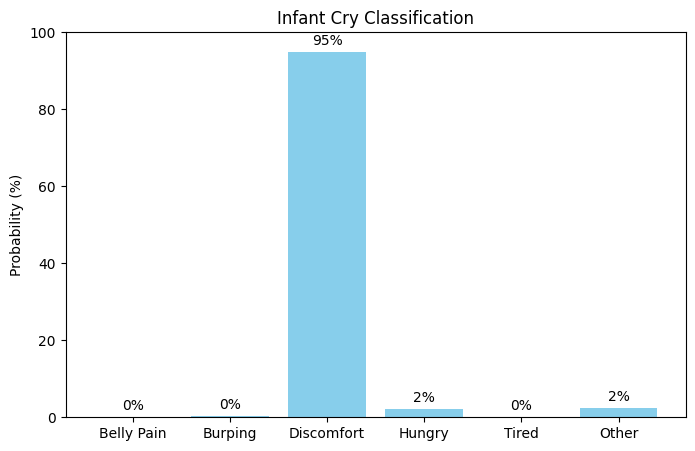

In [55]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("⚠ No GPU found, using CPU.")

FILENAME = r"C:\Users\FUJITSU\Documents\AudiosforTest\test.wav"  # File to read


@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


my_classes = ['Belly Pain', 'Burping', 'Discomfort', 'Hungry', 'Tired', 'Other']

saved_model_path = './model'  # Trained model path

reloaded_model = tf.saved_model.load(saved_model_path)

# Run prediction
logits = reloaded_model(load_wav_16k_mono(FILENAME))  # Output shape: (1, 5) most likely
logits = tf.squeeze(logits)  # Now shape: (5,)
probs = tf.nn.softmax(logits).numpy() * 100  # Now a NumPy array with 5 probabilities

# Get result
result = my_classes[np.argmax(probs)]

# Print main sound
print(f"\nThe main sound is: {result}")

# Print probabilities nicely
print("\nProbabilities:")
for cls, prob in zip(my_classes, probs):
    print(f"{cls.ljust(12)} {prob:.0f}%")

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(my_classes, probs, color='skyblue')

# Add percentage labels
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1, f'{prob:.0f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel("Probability (%)")
plt.title("Infant Cry Classification")
plt.show()

In [7]:
# %% Convert to TFLite
import tensorflow as tf

# Load the saved model
saved_model_path = r'C:\Users\FUJITSU\Documents\Model'
model = tf.keras.models.load_model(saved_model_path)

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimizations for deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = r'C:\Users\FUJITSU\Documents\New_model\Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Model converted to TFLite and saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\FUJITSU\AppData\Local\Temp\tmplmyto0rg\assets


INFO:tensorflow:Assets written to: C:\Users\FUJITSU\AppData\Local\Temp\tmplmyto0rg\assets


✅ Model converted to TFLite and saved to C:\Users\FUJITSU\Documents\New_model\Model.tflite
